In [2]:
#import packages
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as sps
import scipy.optimize as spop
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


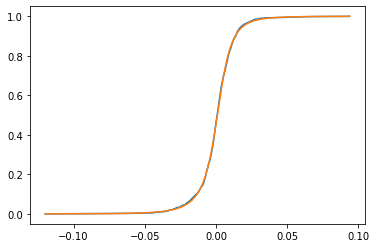

The p-value of the Kolmorogov-Smirnov test equals 71.1557%
The distribution fits the data


In [21]:
#Johnson SU distribution
#probability density function: f(x) = scale2/(scale1*sqrt(2*pi))/sqrt(1+((x-loc1)/scale1)^2)*e^(-1/2*(loc2 + scale2*arcsinh((x-loc1)/scale1))^2)
#cumulative distribution function: F(x) = N(loc2 + scale2*arcsinh((x-loc1)/scale1))
#specify the sample
ticker = '^GSPC'
start = '2017-12-31' 
end = '2022-12-31'
#retrieve data
prices = yf.download(ticker, start, end)['Close']
#calculate and sort returns
returns = np.array(prices[1:])/np.array(prices[:-1]) - 1
returns = np.sort(returns)
#construct empirical distribution function
edf = np.arange(1, len(returns)+1)/len(returns)
#calculate mean and standard deviation
mean = np.average(returns)
std = np.std(returns)
#optimise Johnson SU distribution parameters using maximum likelihood estimation
def johnson_su_optimisation(k):
    k[1] = abs(k[1])
    k[3] = abs(k[3])
    pdf = k[3]/(k[1]*(2*np.pi)**(1/2))/(1 + ((returns - k[0])/k[1])**2)**(1/2)*np.exp(-1/2*(k[2] + k[3]*np.arcsinh((returns - k[0])/k[1]))**2)
    return -np.sum(np.log(pdf))
#retrieve optimal distribution parameters
res = spop.minimize(johnson_su_optimisation, [mean, std, 0, 1], method='Nelder-Mead')
su_loc_1 = res.x[0]
su_scale_1 = abs(res.x[1])
su_loc_2 = res.x[2]
su_scale_2 = abs(res.x[3])
#calculate the cumulative distribution function
cdf = sps.norm.cdf(su_loc_2 + su_scale_2*np.arcsinh((returns - su_loc_1)/su_scale_1))
#visualise the distribution functions
plt.plot(returns, edf)
plt.plot(returns, cdf)
plt.show()
#evaluate the goodness-of-fit using Kolmogorov-Smirnov test
supremum = max(abs(edf - cdf))
p_value = np.exp(-supremum**2*len(returns))
print('The p-value of the Kolmorogov-Smirnov test equals '+str(round(p_value*100,4))+'%')
if p_value < 0.1:
    print('The distribution does not fit the data')
else:
    print('The distribution fits the data')